<a href="https://colab.research.google.com/github/kalebmes/ML-and-DL-projects/blob/main/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 5.5 MB/s 
     |████████████████████████████████| 376 kB 51.1 MB/s 
     |████████████████████████████████| 58 kB 6.1 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=f9e8dfe2cce742a019c23d62b15bab0663d2213c642bbc02668aade1dd384ee0
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=36bc6b375af2fd97d1603d1a63b6869e52f13cfeec63edb0648e313a4a765a82
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning htt

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 16.86 MiB/s, done.
Resolving deltas: 100% (3/3), done.


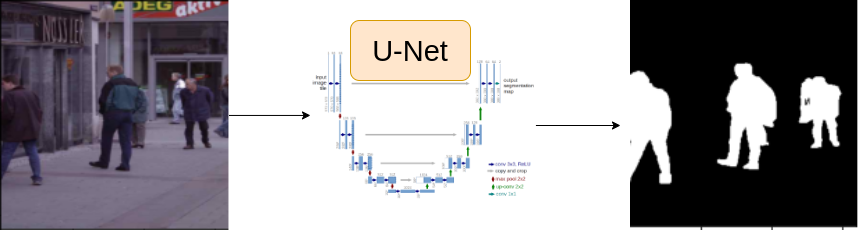

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

#  Setup Configurations

In [ ]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content'

device = 'cuda'
epochs = 25
lr = 1e-3
image_size = 320
batch_size=16

encoder_cnn = 'timm-efficientnet-b0'
weights = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
...,...,...
285,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
286,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
287,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
288,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
# let's try to visualize some images using open-cv
row = df.iloc[3]

image_path = row['images']
mask_path = row['masks']

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

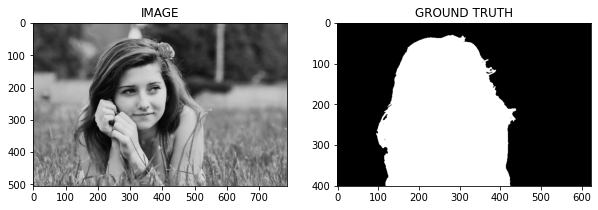

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
# now let's split the dataset into train and valid set
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(image_size, image_size),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(image_size, image_size)
      ])

# : Create Custom Dataset 

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row['images']
    mask_path = row['masks']

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # h w c format
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

      # since our images are in hwc format we have to change them to (c, h, w)

      image = np.transpose(image, (2, 0, 1)).astype(np.float32)
      mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

      image = torch.Tensor(image) / 255.0
      mask = torch.round(torch.Tensor(mask) / 255.0)

      return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())


In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


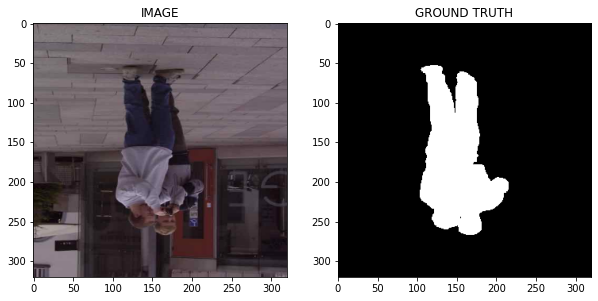

In [ ]:
idx = 10

image, mask = trainset[idx]
helper.show_image(image, mask)

# : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size)

In [ ]:
print(f'total number of batches in train loader: {len(trainloader)}')
print(f'total number of batches in valid loader: {len(validloader)}')


total number of batches in train loader: 15
total number of batches in valid loader: 4


In [ ]:
for image, mask in trainloader:
  break

print(f'One batch image has shape of {image.shape}')
print(f'One batch mask has shape of {mask.shape}')

One batch image has shape of torch.Size([16, 3, 320, 320])
One batch mask has shape of torch.Size([16, 1, 320, 320])


#: Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()
    self.arc = smp.Unet(
        encoder_name = encoder_cnn,
        encoder_weights=weights,
        in_channels = 3,
        classes = 1,
        activation = None
    )
  
  def forward(self, images, masks=None):
    logits = self.arc(images)
    if masks is not None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2
    return logits

In [ ]:
model = SegmentationModel()
model.to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps

#: Create Train and Validation Function 

In [ ]:
def train_fn(data_loader, model, optimizer):
  model.train()

  total_loss = 0.0
  for images, masks in tqdm(data_loader):
    images, masks = images.to(device), masks.to(device)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss / len(data_loader)

In [ ]:
def eval_fn(data_loader, model):
  model.eval()

  total_loss = 0.0
  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images, masks = images.to(device), masks.to(device)

      logits, loss = model(images, masks)

      total_loss += loss.item()
  return total_loss / len(data_loader)

#  Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
best_valid_loss = np.Inf
for i in range(epochs):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('Saved-model')
    best_valid_loss = valid_loss
  print(f'Epoch : {i+1} train loss : {train_loss} Valid loss : {valid_loss}')

100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


Saved-model
Epoch : 1 train loss : 0.44165716171264646 Valid loss : 0.3182833567261696


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


Saved-model
Epoch : 2 train loss : 0.280037855108579 Valid loss : 0.22841866314411163


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Saved-model
Epoch : 3 train loss : 0.22617272635300953 Valid loss : 0.20391859859228134


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


Epoch : 4 train loss : 0.237751500805219 Valid loss : 0.23246550932526588


100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


Saved-model
Epoch : 5 train loss : 0.19190658132235208 Valid loss : 0.18661490082740784


100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Saved-model
Epoch : 6 train loss : 0.17292095025380452 Valid loss : 0.1583143286406994


100%|██████████| 4/4 [00:01<00:00,  2.46it/s]


Epoch : 7 train loss : 0.17043640712896982 Valid loss : 0.17005740106105804


100%|██████████| 4/4 [00:00<00:00,  4.58it/s]


Epoch : 8 train loss : 0.15317407647768658 Valid loss : 0.17700697109103203


100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Epoch : 9 train loss : 0.15413295129934948 Valid loss : 0.19943589344620705


100%|██████████| 4/4 [00:01<00:00,  3.25it/s]


Saved-model
Epoch : 10 train loss : 0.1132267951965332 Valid loss : 0.15206241980195045


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Saved-model
Epoch : 11 train loss : 0.09890165627002716 Valid loss : 0.13652266934514046


100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


Epoch : 12 train loss : 0.11787969867388408 Valid loss : 0.15387215465307236


100%|██████████| 4/4 [00:00<00:00,  4.48it/s]


Epoch : 13 train loss : 0.11678228179613749 Valid loss : 0.19751008227467537


100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


Epoch : 14 train loss : 0.11501738379398982 Valid loss : 0.14869001507759094


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Epoch : 15 train loss : 0.12225214044253031 Valid loss : 0.14996063709259033


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


Epoch : 16 train loss : 0.11836323440074921 Valid loss : 0.13956325128674507


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch : 17 train loss : 0.10916699717442195 Valid loss : 0.19331314601004124


100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Epoch : 18 train loss : 0.1149617776274681 Valid loss : 0.14708014577627182


100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


Epoch : 19 train loss : 0.08266604493061701 Valid loss : 0.1516350544989109


100%|██████████| 4/4 [00:01<00:00,  3.09it/s]


Epoch : 20 train loss : 0.080942485978206 Valid loss : 0.14117774181067944


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


Epoch : 21 train loss : 0.07935726096232733 Valid loss : 0.14061132445931435


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


Epoch : 22 train loss : 0.07681505630413692 Valid loss : 0.1423148326575756


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


Saved-model
Epoch : 23 train loss : 0.06979771479964256 Valid loss : 0.12955746799707413


100%|██████████| 4/4 [00:00<00:00,  4.44it/s]


Epoch : 24 train loss : 0.06929157450795173 Valid loss : 0.13371636532247066


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]

Epoch : 25 train loss : 0.07033639525373776 Valid loss : 0.13155491277575493


# Inference

In [ ]:
idx = 20

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(device).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5 )* 1.0

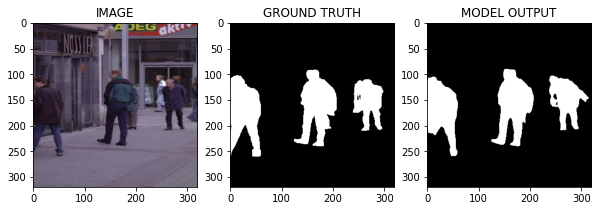

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))